### **Understanding the problem** ###


#### Target Output: `sii`

The `sii` column represents the Severity Impairment Index (SII), which is used to classify the severity of problematic internet use. It follows a scale defined as:

- **0**: None
- **1**: Mild
- **2**: Moderate
- **3**: Severe

Target `sii` is derived from the field `PCIAT-PCIAT_Total`.

#### Data Inputs:

- Internet usage behavior data
    - `Train.csv` (2736 ids has value in `sii`)
- Accelerometer time series data for single `id`, to be used as training data
    - `id.parquet` (available for  996 `id` in total)
    
Number of `id`(s) have both `sii` value and `id.parquet` file: 996

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Data ingestion - Load X, data dictionary ###

In [5]:
# Load csv files into csv_file, within csv_file, each csv file is created as a df using the name of csv file.
csv_file = {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            key = filename.split('.')[0]
            csv_file[key] = pd.read_csv(os.path.join(dirname, filename))
            globals()[key] = csv_file[key] 
            
X = train
print("X shape", X.shape)
print("data_dictionary", data_dictionary.shape)

X shape (3960, 82)
data_dictionary (81, 6)


In [11]:
X = train[train['sii'].notna()] # select rows where column sii is not null in train
id_sii_not_null = train[train['sii'].notna()]['id'].tolist() # get list of ids having non-null sii value.
print("Number of ids that has not null sii in train dataset: ", len(set(id_sii_not_null)))
#y = X['sii']
#y.shape

Number of ids that has not null sii in train dataset:  2736


### Create feature selection pipeline ###

In [17]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, missing_threshold=0.3, cols_to_drop=cols_to_drop):
        self.missing_threshold = missing_threshold
        self.cols_to_drop = cols_to_drop if cols_to_drop else []
        
    def fit(self, X, y=None):
        # Calculate missing percentages for each column
        missing_percent = X.isnull().mean()
        # Get columns with missing values >= threshold
        self.cols_to_drop_missing = missing_percent[missing_percent >= self.missing_threshold].index.tolist()
        
        print("\n=== Step 1: Feature Selection ===")
        print(f"Columns dropped due to missing values (>={self.missing_threshold*100}%): {self.cols_to_drop_missing}")
        print(f"Additional columns specified to drop: {self.cols_to_drop}")
        return self
        
    def transform(self, X):
        # Drop both specified columns and those with too many missing values
        X_selected = X.drop(columns=self.cols_to_drop + self.cols_to_drop_missing)
        print(f"Shape after feature selection: {X_selected.shape}")
        return X_selected


class MissingValueHandler(BaseEstimator, TransformerMixin):
    def fit(self, X_selected, y=None):
        # Store target variable during fit
        X_clean = X_selected[~X_selected.isna().any(axis=1)]  # Drop rows with any missing values
        self.y_ = X_clean['sii'].copy()  # Store target
        print("\n=== Step 2: Missing Value Handling & Target Separation ===")
        print(f"Shape before dropping NA rows: {X_selected.shape}")
        print(f"Shape after dropping NA rows: {X_clean.shape}")
        print("\nTarget value distribution:")
        print(self.y_.value_counts())
        return self
        
    def transform(self, X_selected):
        # Drop rows with missing values and remove target column
        X_clean = X_selected[~X_selected.isna().any(axis=1)]  # Drop rows with any missing values
        X_features = X_clean.drop(columns=['sii'])  # Drop target column
        
        print("\nFirst few rows after cleaning:")
        print(X_features.head(2))
        print(f"\nFinal feature matrix shape: {X_features.shape}")
        return X_features
        
def create_preprocessing_pipeline(
    test_size=0.3,
    random_state=42,
    missing_threshold=0.3,
    cols_to_drop=None
):
    """
    Create preprocessing pipeline that chains feature selection, missing value handling,
    and data splitting.
    """
    # Create pipeline
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(
            missing_threshold=missing_threshold,
            cols_to_drop=cols_to_drop
        )),
        ('missing_handler', MissingValueHandler())
    ])
    
    def process_data(X):
        # 1. Feature Selection
        feature_selector = FeatureSelector(
            missing_threshold=missing_threshold,
            cols_to_drop=cols_to_drop
        )
        X_selected = feature_selector.fit_transform(X)
        
        # 2. Missing Value Handling and Target Separation
        missing_handler = MissingValueHandler()
        X_features = missing_handler.fit_transform(X_selected)
        y = missing_handler.y_  # Get target variable
        
        # 3. Split the data
        X_train, X_val, y_train, y_val = train_test_split(
            X_features, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y
        )
        
        print("\nFinal output shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}") 
        print(f"y_train: {y_train.shape}")
        print(f"y_val: {y_val.shape}")
        
        return X_train, X_val, y_train, y_val
        
    return process_data


In [18]:
# Usage example:
cols_to_drop = [col for col in X.columns if col.startswith('PCIAT-PCIAT')]+['PCIAT-Season']

pipeline = create_preprocessing_pipeline(
    test_size=0.3,
    random_state=42,
    missing_threshold=0.02,
    cols_to_drop = cols_to_drop)

# Process the data
X_train, X_val, y_train, y_val = pipeline(X)


=== Step 1: Feature Selection ===
Columns dropped due to missing values (>=2.0%): ['CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'P

### **Create feature preprocessing pipeline** ###

In [19]:
def create_feature_preprocessing_pipeline(
    data_dictionary,
    X_train, 
    X_val,
    y_train,
    y_val
):
    class FeatureTypeIdentifier(BaseEstimator, TransformerMixin):
        def __init__(self, data_dictionary):
            self.data_dictionary = data_dictionary
            
        def fit(self, X, y=None):
            # Identify categorical and numerical columns
            columns_to_check = [col for col in X.columns if col != 'id']
            
            self.cat_cols = [col for col in columns_to_check if col in 
                            self.data_dictionary[self.data_dictionary['Type'].isin(['categorical int','str'])]['Field'].unique()]
            self.num_cols = [col for col in columns_to_check if col in 
                            self.data_dictionary[~self.data_dictionary['Type'].isin(['categorical int','str'])]['Field'].unique()]
            
            print("\n=== Feature Type Identification ===")
            print(f"Categorical columns ({len(self.cat_cols)}): {self.cat_cols}")
            print(f"Numerical columns ({len(self.num_cols)}): {self.num_cols}")
            return self
            
        def transform(self, X):
            return X

    class FeaturePreprocessor(BaseEstimator, TransformerMixin):
        def __init__(self, X_train, X_val):  # Add X_train and X_val as parameters
            self.scaler = MinMaxScaler()
            self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            self.X_train = X_train
            self.X_val = X_val
            
        def fit(self, X, y=None):
            # Get column types from previous step
            feature_identifier = pipeline.named_steps['feature_identifier']
            self.cat_cols = feature_identifier.cat_cols
            self.num_cols = feature_identifier.num_cols
            
            print("\n=== Feature Preprocessing ===")
            
            # Process numerical features
            if self.num_cols:
                print("\nNumerical Features:")
                print(f"X_train[numerical] shape before scaling: {self.X_train[self.num_cols].shape}")
                print(f"X_val[numerical] shape before scaling: {self.X_val[self.num_cols].shape}")
                
                # Fit scaler on training data
                self.scaler.fit(self.X_train[self.num_cols])
                
                # Transform both sets
                self.X_train_scaled = self.scaler.transform(self.X_train[self.num_cols])
                self.X_val_scaled = self.scaler.transform(self.X_val[self.num_cols])
                
                print(f"X_train[numerical] shape after scaling: {self.X_train_scaled.shape}")
                print(f"X_val[numerical] shape after scaling: {self.X_val_scaled.shape}")
            
            # Process categorical features
            if self.cat_cols:
                print("\nCategorical Features:")
                print(f"X_train[categorical] shape before encoding: {self.X_train[self.cat_cols].shape}")
                print(f"X_val[categorical] shape before encoding: {self.X_val[self.cat_cols].shape}")
                
                # Fit encoder on training data
                self.encoder.fit(self.X_train[self.cat_cols])
                
                # Transform both sets
                self.X_train_encoded = self.encoder.transform(self.X_train[self.cat_cols])
                self.X_val_encoded = self.encoder.transform(self.X_val[self.cat_cols])
                
                self.feature_names = self.encoder.get_feature_names_out(self.cat_cols)
                print(f"X_train[categorical] shape after encoding: {self.X_train_encoded.shape}")
                print(f"X_val[categorical] shape after encoding: {self.X_val_encoded.shape}")
            
            return self
            
        def transform(self, X):
            # Create DataFrames for scaled numerical features
            if self.num_cols:
                X_train_scaled_df = pd.DataFrame(
                    self.X_train_scaled,
                    columns=self.num_cols,
                    index=self.X_train.index
                )
                X_val_scaled_df = pd.DataFrame(
                    self.X_val_scaled,
                    columns=self.num_cols,
                    index=self.X_val.index
                )
            
            # Create DataFrames for encoded categorical features
            if self.cat_cols:
                X_train_encoded_df = pd.DataFrame(
                    self.X_train_encoded,
                    columns=self.feature_names,
                    index=self.X_train.index
                )
                X_val_encoded_df = pd.DataFrame(
                    self.X_val_encoded,
                    columns=self.feature_names,
                    index=self.X_val.index
                )
            
            # Combine features for training set
            train_parts = []
            if self.num_cols:
                train_parts.append(X_train_scaled_df)
            if self.cat_cols:
                train_parts.append(X_train_encoded_df)
            self.X_train_processed = pd.concat(train_parts, axis=1)
            
            # Combine features for validation set
            val_parts = []
            if self.num_cols:
                val_parts.append(X_val_scaled_df)
            if self.cat_cols:
                val_parts.append(X_val_encoded_df)
            self.X_val_processed = pd.concat(val_parts, axis=1)
            
            print("\nFinal feature matrices:")
            print(f"X_train_processed shape: {self.X_train_processed.shape}")
            print(f"X_val_processed shape: {self.X_val_processed.shape}")
            
            return self.X_train_processed if X is self.X_train else self.X_val_processed

    # Create and run pipeline
    pipeline = Pipeline([
        ('feature_identifier', FeatureTypeIdentifier(data_dictionary)),
        ('preprocessor', FeaturePreprocessor(X_train, X_val))
    ])
    
    # Process features
    X_train_processed = pipeline.fit_transform(X_train)
    X_val_processed = pipeline.transform(X_val)
    
    # Process target variables
    print("\n=== Target Variable Encoding ===")
    y_encoder = OneHotEncoder(sparse_output=False)
    y_train_processed = y_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_val_processed = y_encoder.transform(y_val.values.reshape(-1, 1))
    
    print(f"y_train shape before encoding: {y_train.shape}")
    print(f"y_val shape before encoding: {y_val.shape}")
    print(f"y_train shape after encoding: {y_train_processed.shape}")
    print(f"y_val shape after encoding: {y_val_processed.shape}")
    
    return X_train_processed, X_val_processed, y_train_processed, y_val_processed

In [20]:
X_train_processed, X_val_processed, y_train_processed, y_val_processed = create_feature_preprocessing_pipeline(
    data_dictionary=data_dictionary,
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val
)


=== Feature Type Identification ===
Categorical columns (3): ['Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'PreInt_EduHx-Season']
Numerical columns (1): ['Basic_Demos-Age']

=== Feature Preprocessing ===

Numerical Features:
X_train[numerical] shape before scaling: (1903, 1)
X_val[numerical] shape before scaling: (816, 1)
X_train[numerical] shape after scaling: (1903, 1)
X_val[numerical] shape after scaling: (816, 1)

Categorical Features:
X_train[categorical] shape before encoding: (1903, 3)
X_val[categorical] shape before encoding: (816, 3)
X_train[categorical] shape after encoding: (1903, 10)
X_val[categorical] shape after encoding: (816, 10)

Final feature matrices:
X_train_processed shape: (1903, 11)
X_val_processed shape: (816, 11)

Final feature matrices:
X_train_processed shape: (1903, 11)
X_val_processed shape: (816, 11)

=== Target Variable Encoding ===
y_train shape before encoding: (1903,)
y_val shape before encoding: (816,)
y_train shape after encoding: (1903, 4)
y_val

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train_processed, axis=1)
classes = np.unique(y_train_labels)

class_weights = compute_class_weight('balanced', classes = classes, y = y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.4297651309846432,
 1: 0.932843137254902,
 2: 1.8158396946564885,
 3: 19.822916666666668}

In [65]:
class_weights_dict

{0: 0.4297651309846432,
 1: 0.932843137254902,
 2: 1.8158396946564885,
 3: 19.822916666666668}

### **Feed-Forward Neural Network Model** ###

In [24]:
tf.random.set_seed(1234)
np.random.seed(1234)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_model(X_train, y_train, X_val, y_val, learning_rate, num_features,num_epochs = 10, batch_size = 32):
    tf.keras.backend.clear_session()
     # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()

# Add a hidden layer with 64 neurons and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=256,                    # Number of neurons in the hidden layer
        activation='relu',          # ReLU activation for hidden layer
        input_shape=(X_train.shape[1],),
        kernel_regularizer=l2(0.001) # Use number of features in X_train
    ))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))  # Dropout with 30% probability


    
  # Output layer with softmax activation
    model.add(tf.keras.layers.Dense(
        units=4,                    # Output layer with the number of classes
        activation='softmax',     # softmax activation
        kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
    ))
  
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=0.01)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # set schedule to adjust learning rate 
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
       lambda epoch: learning_rate * (0.1 ** (epoch // 5))
    )
  
     # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=3,          # Stop if no improvement after 3 epochs
        restore_best_weights=True  # Restore model weights from the best epoch
    )

  # Step 3: Train the Model
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=2,
        class_weight=class_weights_dict,
        callbacks=[lr_schedule, early_stopping]
    )
  
    return model

In [25]:
num_features = X_train_processed.shape[1]
model_tf = build_model(
    X_train = X_train_processed, 
    y_train = y_train_processed, 
    X_val = X_val_processed, 
    y_val  = y_val_processed, 
    num_features=num_features, 
    num_epochs = 25, 
    learning_rate=0.01)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 1s - 20ms/step - accuracy: 0.2953 - loss: 1.4973 - val_accuracy: 0.1238 - val_loss: 1.4437 - learning_rate: 0.0100
Epoch 2/25
60/60 - 0s - 3ms/step - accuracy: 0.3836 - loss: 1.3628 - val_accuracy: 0.2549 - val_loss: 1.3749 - learning_rate: 0.0100
Epoch 3/25
60/60 - 0s - 3ms/step - accuracy: 0.4073 - loss: 1.3242 - val_accuracy: 0.3640 - val_loss: 1.3269 - learning_rate: 0.0100
Epoch 4/25
60/60 - 0s - 3ms/step - accuracy: 0.4235 - loss: 1.3013 - val_accuracy: 0.4559 - val_loss: 1.2907 - learning_rate: 0.0100
Epoch 5/25
60/60 - 0s - 2ms/step - accuracy: 0.4435 - loss: 1.2880 - val_accuracy: 0.4828 - val_loss: 1.2544 - learning_rate: 0.0100
Epoch 6/25
60/60 - 0s - 3ms/step - accuracy: 0.4388 - loss: 1.2048 - val_accuracy: 0.4779 - val_loss: 1.2493 - learning_rate: 0.0010
Epoch 7/25
60/60 - 0s - 2ms/step - accuracy: 0.4598 - loss: 1.1766 - val_accuracy: 0.4632 - val_loss: 1.2494 - learning_rate: 0.0010
Epoch 8/25
60/60 - 0s - 2ms/step - accuracy: 0.4640 - loss: 1.1714 - val_accura

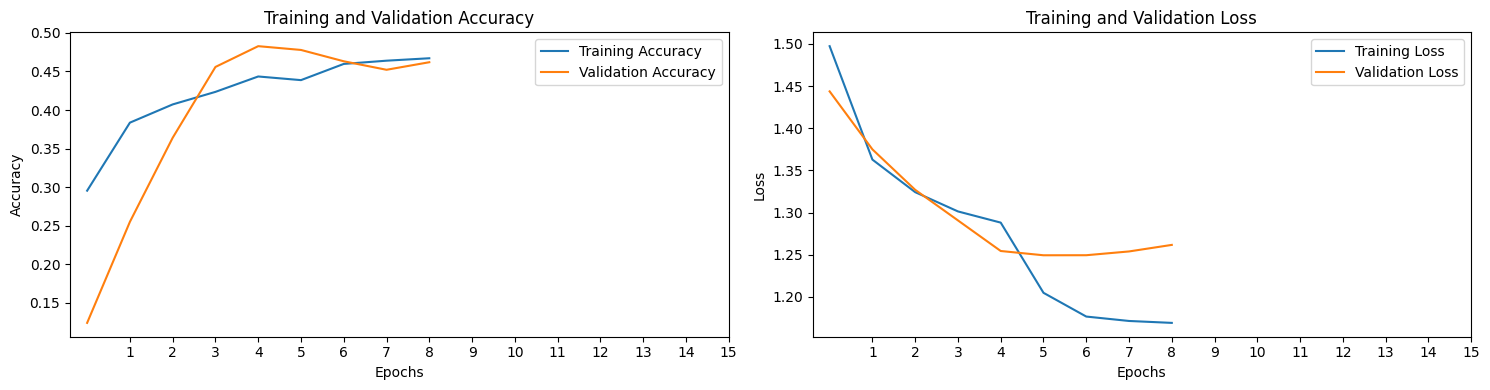

In [26]:
history = model_tf.history.history
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xticks(ticks = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xticks(ticks = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### **Random Forest** ###

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_processed, y_train_processed)

# Predict on validation set
rf_y_pred = rf_model.predict(X_val_processed)

# Evaluate
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_val_processed, rf_y_pred))
print(classification_report(y_val_processed, rf_y_pred))

Random Forest Results:
Accuracy: 0.20465686274509803
              precision    recall  f1-score   support

           0       0.73      0.24      0.36       475
           1       0.27      0.15      0.19       218
           2       0.23      0.17      0.19       113
           3       0.04      0.10      0.06        10

   micro avg       0.43      0.20      0.28       816
   macro avg       0.32      0.16      0.20       816
weighted avg       0.53      0.20      0.29       816
 samples avg       0.20      0.20      0.20       816



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN ###

In [70]:

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn_model.fit(X_train_processed, y_train_processed)

# Predict on validation set
knn_y_pred = knn_model.predict(X_val_processed)

# Evaluate
print("KNN Results:")
print("Accuracy:", accuracy_score(y_val_processed, knn_y_pred))
print(classification_report(y_val_processed, knn_y_pred))

KNN Results:
Accuracy: 0.4693627450980392
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       475
           1       0.29      0.10      0.14       218
           2       0.25      0.12      0.16       113
           3       0.00      0.00      0.00        10

   micro avg       0.59      0.47      0.52       816
   macro avg       0.30      0.24      0.25       816
weighted avg       0.50      0.47      0.47       816
 samples avg       0.47      0.47      0.47       816



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression ###

In [72]:
# Logistic Regression
lr_model = LogisticRegression(
    multi_class='multinomial',  # Use 'ovr' for one-vs-rest
    solver='lbfgs',             # Recommended for multinomial
    max_iter=1000,              # Increase if convergence warning occurs
    class_weight='balanced',    # Adjust for class imbalance
    random_state=42
)
lr_model.fit(X_train_processed, y_train)

# Predict on validation set
lr_y_pred = lr_model.predict(X_val_processed)

# Evaluate
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_val, lr_y_pred))
print(classification_report(y_val, lr_y_pred))

Logistic Regression Results:
Accuracy: 0.5147058823529411
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73       475
         1.0       0.43      0.23      0.30       218
         2.0       0.23      0.21      0.22       113
         3.0       0.04      0.50      0.07        10

    accuracy                           0.51       816
   macro avg       0.36      0.42      0.33       816
weighted avg       0.58      0.51      0.54       816



### **Evaluation & Generalization** ###

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


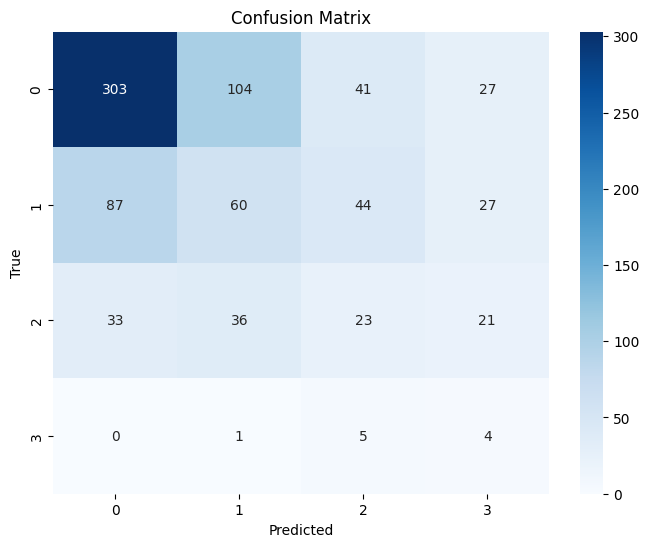

Weighted AUCPR: 0.541
              precision    recall  f1-score   support

         0.0       0.72      0.64      0.67       475
         1.0       0.30      0.28      0.29       218
         2.0       0.20      0.20      0.20       113
         3.0       0.05      0.40      0.09        10

    accuracy                           0.48       816
   macro avg       0.32      0.38      0.31       816
weighted avg       0.53      0.48      0.50       816



In [76]:
# Calculate confusion matrix of model_tf
#1. get prediction on validation set 
y_pred_prob = model_tf.predict(X_val_processed)
y_pred = np.argmax(y_pred_prob, axis = 1).tolist()

#2. get true class labels of validation set
y_true = y_val.tolist()

#3. calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#4. plot the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = [0,1,2,3],yticklabels = [0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import numpy as np

# Ensure y_true is a NumPy array
y_true = np.array(y_true)  # Convert y_true to a NumPy array if not already

# Identify the number of classes
num_classes = y_pred_prob.shape[1]

# Compute the support (number of samples) for each class
class_counts = np.array([np.sum(y_true == i) for i in range(num_classes)])

# Compute AUCPR for each class
aucpr_scores = []
for class_index in range(num_classes):
    # Create binary labels for the current class
    binary_true = (y_true == class_index).astype(int)
    
    # Compute AUCPR for this class
    aucpr = average_precision_score(binary_true, y_pred_prob[:, class_index])
    aucpr_scores.append(aucpr)

# Compute the weighted AUCPR
total_samples = len(y_true)
weighted_aucpr = np.sum(np.array(aucpr_scores) * (class_counts / total_samples))

# Display the result
print(f"Weighted AUCPR: {weighted_aucpr:.3f}")
report = classification_report(y_true, y_pred)
print(report)

In [263]:
from sklearn.metrics import cohen_kappa_score
def quadratic_weighted_kappa2(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_score2 = quadratic_weighted_kappa2(y_true, y_pred)
print("Quadratic Weighted Kappa2:", kappa_score2)

Quadratic Weighted Kappa2: 0.22573117202536097


In [176]:
accurcy_score = accuracy_score(y_true, y_pred)
accurcy_score

0.5057471264367817

In [ ]:
f1 = f1_score(y_true, y_pred, average = None)
f1

In [ ]:
print("y_pred:",y_pred)
print("y_true:",y_true)

In [ ]:
test = to_categorical(y_pred, num_classes = 4)
test

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)
auc = metrics.auc(fpr,tpr)
print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:",thresholds)
print("auc:", auc)

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# Convert y_true and y_pred to NumPy arrays
y_true_v = to_categorical(y_true, num_classes = 4)
y_pred_v = to_categorical(y_pred, num_classes = 4)

# Binarize the true labels
classes = np.unique(y_true)  # Unique class labels
y_true_binarized = label_binarize(y_true, classes=classes)

# Initialize dictionaries to store results
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Compute ROC and AUC for each class
for i, class_label in enumerate(classes):
    fpr_dict[class_label], tpr_dict[class_label], thresholds = metrics.roc_curve(
        y_true_binarized[:, i], y_pred_v[:, i]
    )
    roc_auc_dict[class_label] = metrics.auc(fpr_dict[class_label], tpr_dict[class_label])

# Macro-averaged AUC
macro_auc = np.mean(list(roc_auc_dict.values()))

# Plot ROC curves
plt.figure(figsize=(10, 7))
for class_label in classes:
    plt.plot(
        fpr_dict[class_label],
        tpr_dict[class_label],
        label=f"Class {class_label} (AUC = {roc_auc_dict[class_label]:.2f})",
    )

# Add macro-averaged ROC curve
all_fpr = np.unique(np.concatenate([fpr_dict[class_label] for class_label in classes]))
mean_tpr = np.zeros_like(all_fpr)
for class_label in classes:
    mean_tpr += np.interp(all_fpr, fpr_dict[class_label], tpr_dict[class_label])
mean_tpr /= len(classes)

plt.plot(all_fpr, mean_tpr, linestyle="--", color="black", label=f"Macro-Averaged (AUC = {macro_auc:.2f})")

# Add plot details
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.grid()
plt.show()

# Print AUC results
print("AUC for each class:")
for class_label in classes:
    print(f"Class {class_label}: {roc_auc_dict[class_label]:.2f}")
print(f"Macro-Averaged AUC: {macro_auc:.2f}")

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
n_classes = 4
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the macro-average AUC (mean AUC across all classes)
macro_auc = np.mean(list(roc_auc.values()))

# Print results
print("ROC and AUC for each class:")
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"  AUC: {roc_auc[i]:.2f}")

print("\nMacro-Averaged AUC:")
print(f"  Macro AUC: {macro_auc:.2f}")


In [ ]:
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    # Create confusion matrix (O matrix)
    O = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Create weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    
    # Calculate histograms
    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    
    # Create expected matrix E
    E = np.outer(actual_hist, pred_hist) / np.sum(O)
    
    # Calculate kappa
    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    kappa = 1 - (numerator / denominator)
    
    return kappa

num_classes = 4  
y_true = np.argmax(y_val_v, axis=1)  # Convert one-hot labels to integer class labels
y_pred = np.argmax(model_tf.predict(X_val_enc), axis=1)

kappa_score = quadratic_weighted_kappa(y_true, y_pred, num_classes)
print("Quadratic Weighted Kappa:", kappa_score)


### # Step 1: Get classification report to calculate the number of instances for each class
report = classification_report(y_true, np.argmax(y_pred_prob, axis=1), output_dict=True)

# Step 2: Print the report to understand its structure
print("Classification Report:")
print(report)

# Step 3: Identify the class labels directly from the report
# We use the keys from the report excluding the 'accuracy', 'macro avg', 'weighted avg'
class_labels = [key for key in report.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]

# Step 4: Get the number of true instances for each class
class_counts = np.array([report[label]['support'] for label in class_labels])

# Step 5: Compute the AUCPR for each class
aucpr_scores = []
for class_index in range(y_pred_prob.shape[1]):  # Loop through each class
    # Create binary labels for the current class
    binary_true = (y_true == class_index).astype(int)
    
    # Compute precision-recall curve for the current class
    precision, recall, _ = precision_recall_curve(binary_true, y_pred_prob[:, class_index])
    
    # Compute AUCPR for this class
    aucpr = average_precision_score(binary_true, y_pred_prob[:, class_index])
    aucpr_scores.append(aucpr)

# Step 6: Calculate the weighted macro average AUCPR
total_samples = len(y_true)
weighted_aucpr = np.sum(np.array(aucpr_scores) * (class_counts / total_samples))

# Display the results
print(f"Macro-weighted AUCPR: {weighted_aucpr:.3f}")

# Optionally, print individual class AUCPRs
for idx, score in enumerate(aucpr_scores):
    print(f"Class {idx} AUCPR: {score:.3f}")non_cat_cols**Get test result** ###

In [ ]:
# Load ids contained in parquet files name into list_id 
#list_id = []
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
#        if filename.endswith('.parquet'):
 #           string = os.path.join(dirname, filename)
 #           id = string.split('/')[-2].split('=')[-1]
 #           list_id.append(id)
# count number of ids contained in parquet files name            
#num_id = len(set(list_id))
#print(num_id)

# load first paquet file 
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       if filename.endswith('.parquet'):
 #           parquet_file1 = pd.read_parquet(os.path.join(dirname, filename))
 #           break
#parquet_file1.shape

In [ ]:
list_id = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            list_id.append(id)
            
num_id = len(set(list_id))
print(num_id)

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            df_0 = pd.read_parquet(os.path.join(dirname, filename))
            break